# Conv2D PyTorch Layers with Batch Normalization

This notebook demonstrates how to use PyTorch Conv2d layers with:
- 2 convolutional layers
- Batch normalization
- Example forward pass
- Training loop demonstration

## 1. Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# mps is Metal Performance Shaders available on MX macbooks

Using device: cpu


In [15]:
torch.backends.mps.is_available()

False

## 2. Define CNN Model with Conv2D and Batch Normalization

In [2]:
class SimpleCNN(nn.Module):
    """
    Simple CNN with 2 convolutional layers and batch normalization.
    
    Architecture:
    - Conv2D Layer 1: 1 input channel, 32 output channels, 3x3 kernel
    - BatchNorm2D
    - ReLU activation
    - MaxPool2D
    - Conv2D Layer 2: 32 input channels, 64 output channels, 3x3 kernel
    - BatchNorm2D
    - ReLU activation
    - MaxPool2D
    - Fully connected layers
    """
    
    def __init__(self, input_channels=1, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        # For 28x28 input: after conv1+pool1 -> 14x14, after conv2+pool2 -> 7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)           # Conv2D
        x = self.bn1(x)             # Batch Normalization
        x = F.relu(x)               # Activation
        x = self.pool1(x)           # Pooling
        
        # Second convolutional block
        x = self.conv2(x)           # Conv2D
        x = self.bn2(x)             # Batch Normalization
        x = F.relu(x)               # Activation
        x = self.pool2(x)           # Pooling
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Create model instance
model = SimpleCNN(input_channels=1, num_classes=10).to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## 3. Model Summary and Parameter Count

In [3]:
def count_parameters(model):
    """Count the number of trainable parameters in the model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params:,}")

# Detailed parameter breakdown
print("\nParameter breakdown by layer:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name:30s} {param.shape} = {param.numel():,} parameters")

Total trainable parameters: 421,834

Parameter breakdown by layer:
conv1.weight                   torch.Size([32, 1, 3, 3]) = 288 parameters
conv1.bias                     torch.Size([32]) = 32 parameters
bn1.weight                     torch.Size([32]) = 32 parameters
bn1.bias                       torch.Size([32]) = 32 parameters
conv2.weight                   torch.Size([64, 32, 3, 3]) = 18,432 parameters
conv2.bias                     torch.Size([64]) = 64 parameters
bn2.weight                     torch.Size([64]) = 64 parameters
bn2.bias                       torch.Size([64]) = 64 parameters
fc1.weight                     torch.Size([128, 3136]) = 401,408 parameters
fc1.bias                       torch.Size([128]) = 128 parameters
fc2.weight                     torch.Size([10, 128]) = 1,280 parameters
fc2.bias                       torch.Size([10]) = 10 parameters


## 4. Test Forward Pass with Sample Input

In [4]:
# Create a sample input tensor (batch_size=4, channels=1, height=28, width=28)
sample_input = torch.randn(4, 1, 28, 28).to(device)
print(f"Input shape: {sample_input.shape}")

# Forward pass
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = model(sample_input)

print(f"Output shape: {output.shape}")
print(f"\nOutput (logits):")
print(output)

# Apply softmax to get probabilities
probabilities = F.softmax(output, dim=1)
print(f"\nProbabilities:")
print(probabilities)
print(f"\nSum of probabilities per sample: {probabilities.sum(dim=1)}")

Input shape: torch.Size([4, 1, 28, 28])
Output shape: torch.Size([4, 10])

Output (logits):
tensor([[-0.0823, -0.1356, -0.0207,  0.1013,  0.0016,  0.0531,  0.0187, -0.0191,
          0.0917, -0.1738],
        [-0.0310, -0.1178, -0.0024,  0.1115,  0.0679,  0.0548, -0.0260,  0.0314,
          0.1025, -0.2094],
        [-0.0636, -0.2101,  0.0332,  0.0909,  0.0135,  0.1076,  0.0004, -0.0050,
          0.1123, -0.1886],
        [-0.1003, -0.1961, -0.0095,  0.0706,  0.0424,  0.0677,  0.0419,  0.0363,
          0.1499, -0.2208]])

Probabilities:
tensor([[0.0933, 0.0884, 0.0992, 0.1121, 0.1015, 0.1068, 0.1032, 0.0994, 0.1110,
         0.0851],
        [0.0967, 0.0887, 0.0995, 0.1115, 0.1068, 0.1054, 0.0972, 0.1029, 0.1105,
         0.0809],
        [0.0943, 0.0815, 0.1039, 0.1101, 0.1019, 0.1120, 0.1006, 0.1000, 0.1125,
         0.0832],
        [0.0909, 0.0826, 0.0996, 0.1079, 0.1049, 0.1076, 0.1048, 0.1042, 0.1168,
         0.0806]])

Sum of probabilities per sample: tensor([1.0000, 1.0000, 

## 5. Visualize Feature Maps

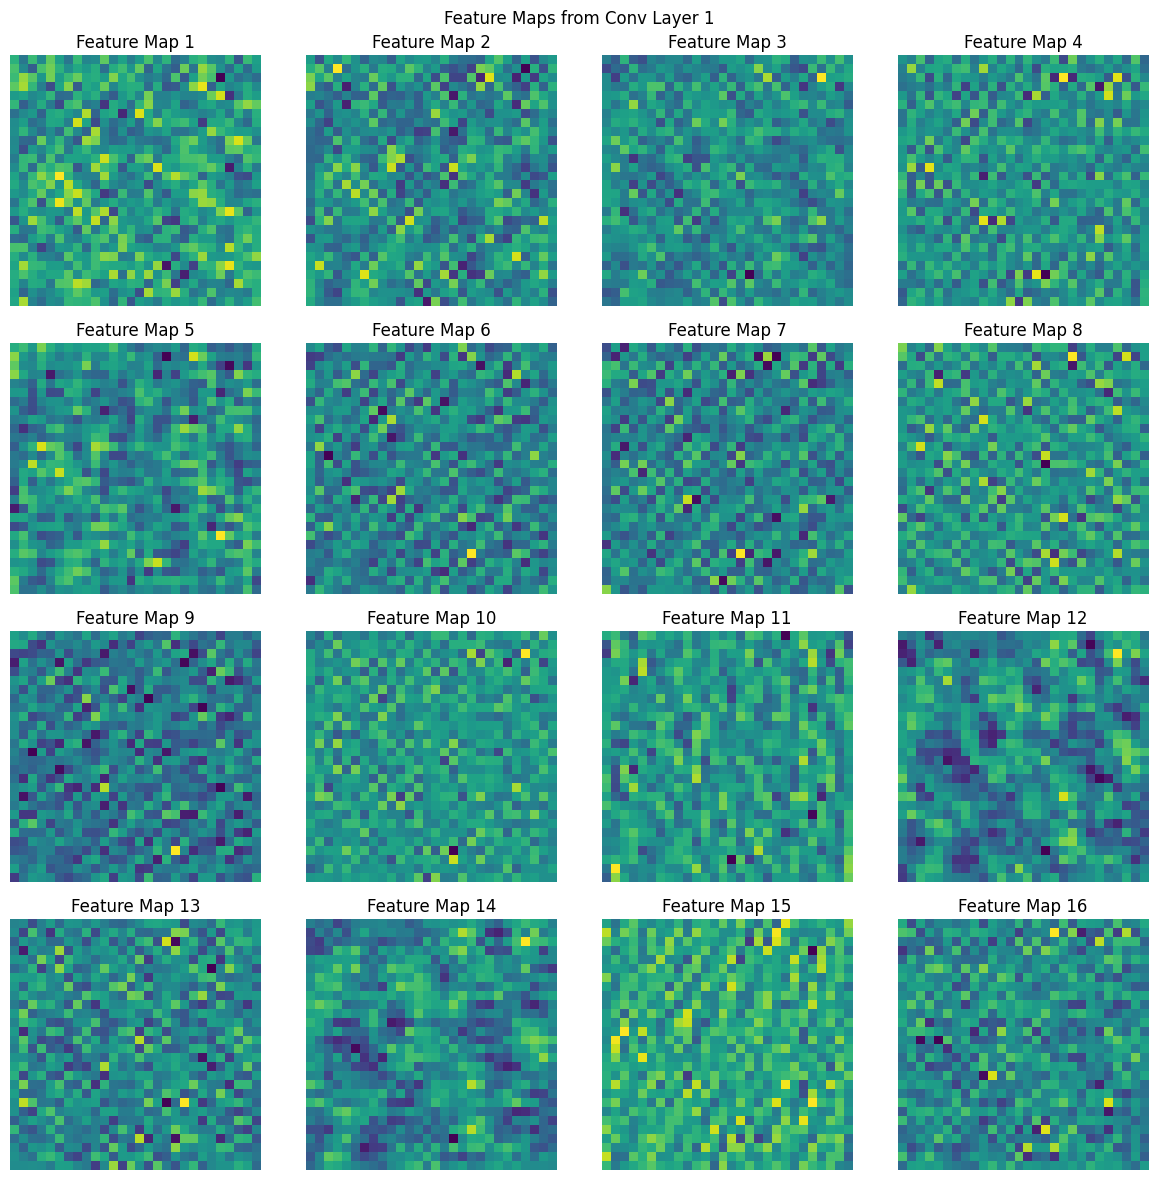

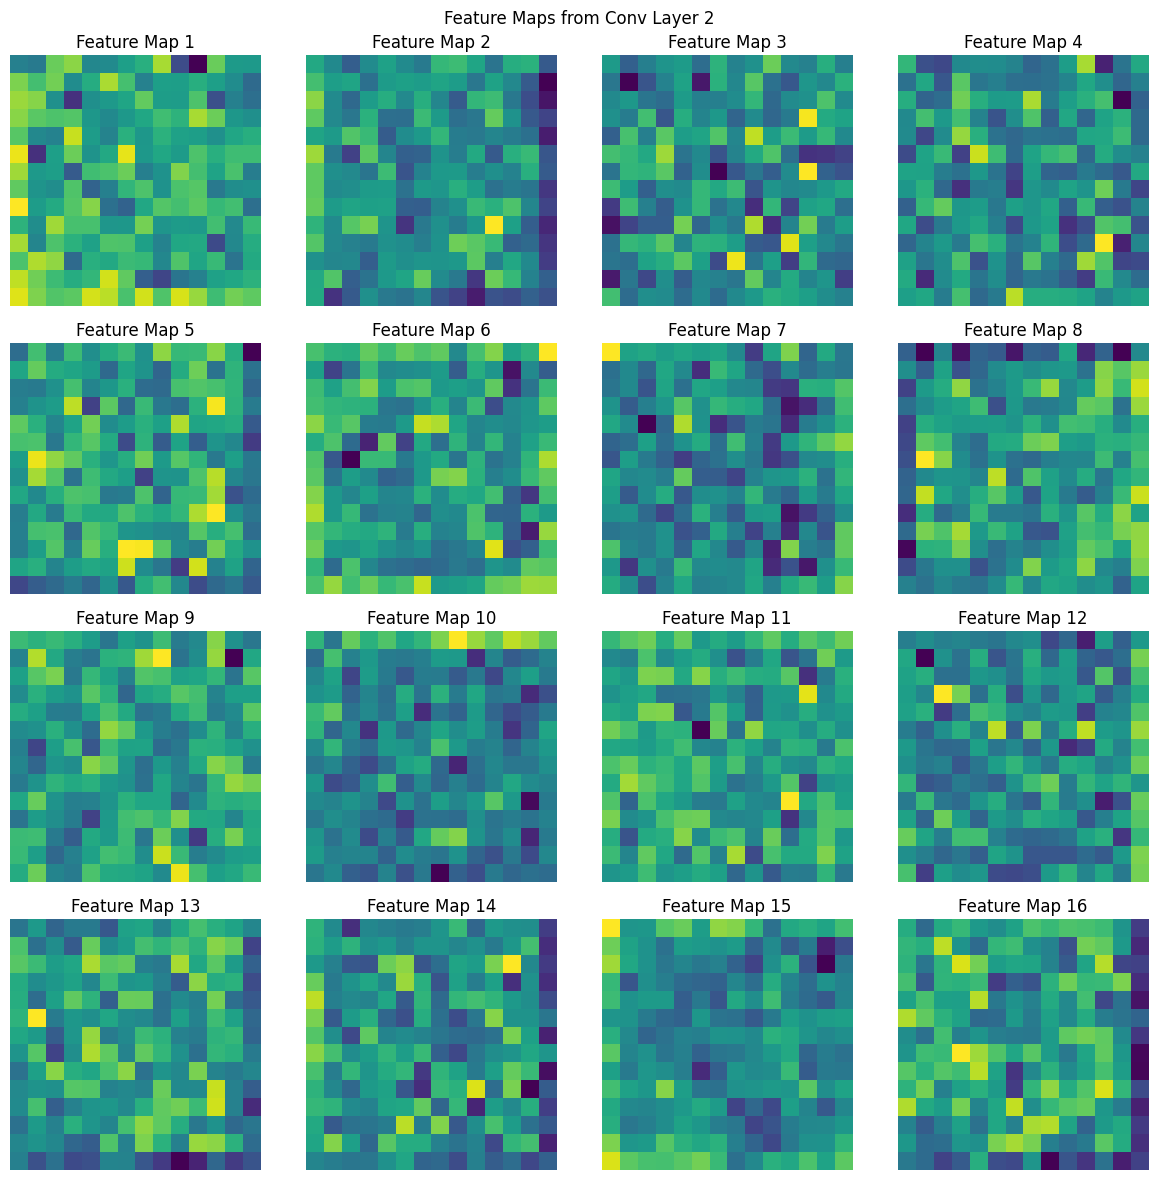

In [5]:
def visualize_feature_maps(model, input_tensor, layer_num=1):
    """Visualize feature maps from a convolutional layer."""
    model.eval()
    
    # Hook to capture feature maps
    feature_maps = []
    def hook_fn(module, input, output):
        feature_maps.append(output)
    
    # Register hook
    if layer_num == 1:
        hook = model.conv1.register_forward_hook(hook_fn)
    else:
        hook = model.conv2.register_forward_hook(hook_fn)
    
    # Forward pass
    with torch.no_grad():
        _ = model(input_tensor)
    
    # Remove hook
    hook.remove()
    
    # Get feature maps
    features = feature_maps[0].cpu().numpy()
    
    # Plot first 16 feature maps
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i in range(min(16, features.shape[1])):
        ax = axes[i // 4, i % 4]
        ax.imshow(features[0, i], cmap='viridis')
        ax.set_title(f'Feature Map {i+1}')
        ax.axis('off')
    plt.suptitle(f'Feature Maps from Conv Layer {layer_num}')
    plt.tight_layout()
    plt.show()

# Visualize feature maps from both conv layers
sample_image = torch.randn(1, 1, 28, 28).to(device)
visualize_feature_maps(model, sample_image, layer_num=1)
visualize_feature_maps(model, sample_image, layer_num=2)

## 6. Load MNIST Dataset

In [6]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of batches per epoch: {len(train_loader)}")

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training samples: 60000
Test samples: 10000
Number of batches per epoch: 938


## 7. Visualize Sample Data

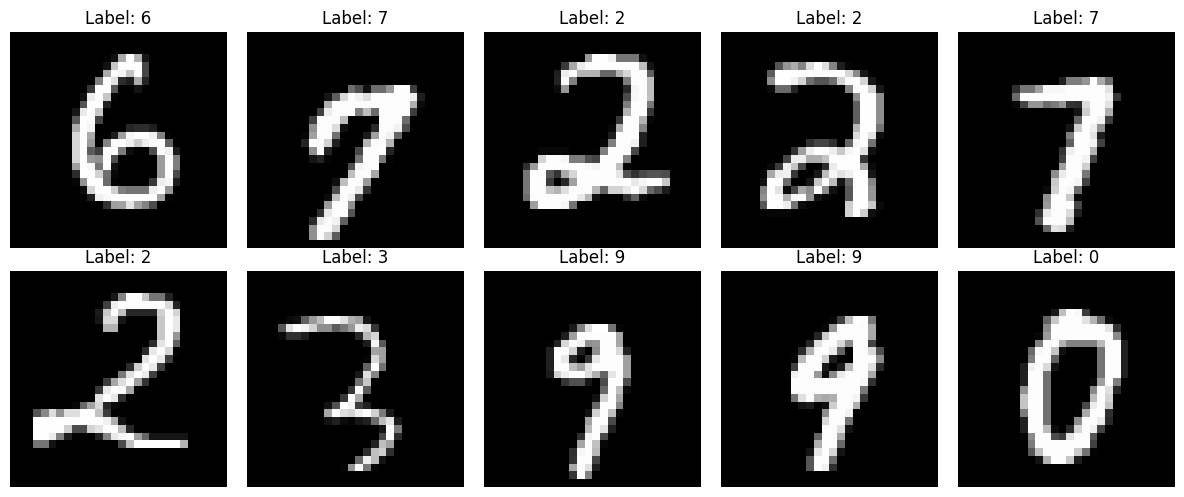

In [7]:
# Visualize some training samples
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(example_data[i][0], cmap='gray')
    ax.set_title(f'Label: {example_targets[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## 8. Training Loop

In [16]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, test_loader, criterion, device):
    """Evaluate the model on test set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100.0 * correct / total
    return test_loss, test_acc

In [9]:
# Train the model
num_epochs = 3
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print("\nTraining complete!")

Starting training...

Epoch 1/3
--------------------------------------------------
Batch 0/938, Loss: 2.2944
Batch 100/938, Loss: 0.4050
Batch 200/938, Loss: 0.1584
Batch 300/938, Loss: 0.2605
Batch 400/938, Loss: 0.2523
Batch 500/938, Loss: 0.1193
Batch 600/938, Loss: 0.1771
Batch 700/938, Loss: 0.1439
Batch 800/938, Loss: 0.2297
Batch 900/938, Loss: 0.1002

Train Loss: 0.2124, Train Acc: 93.48%
Test Loss: 0.0586, Test Acc: 98.12%

Epoch 2/3
--------------------------------------------------
Batch 0/938, Loss: 0.1562
Batch 100/938, Loss: 0.0865
Batch 200/938, Loss: 0.1108
Batch 300/938, Loss: 0.0758
Batch 400/938, Loss: 0.1306
Batch 500/938, Loss: 0.0291
Batch 600/938, Loss: 0.1230
Batch 700/938, Loss: 0.0143
Batch 800/938, Loss: 0.1603
Batch 900/938, Loss: 0.0497

Train Loss: 0.0982, Train Acc: 97.09%
Test Loss: 0.0571, Test Acc: 98.22%

Epoch 3/3
--------------------------------------------------
Batch 0/938, Loss: 0.0450
Batch 100/938, Loss: 0.0465
Batch 200/938, Loss: 0.1516
Batch

## 9. Visualize Training Results

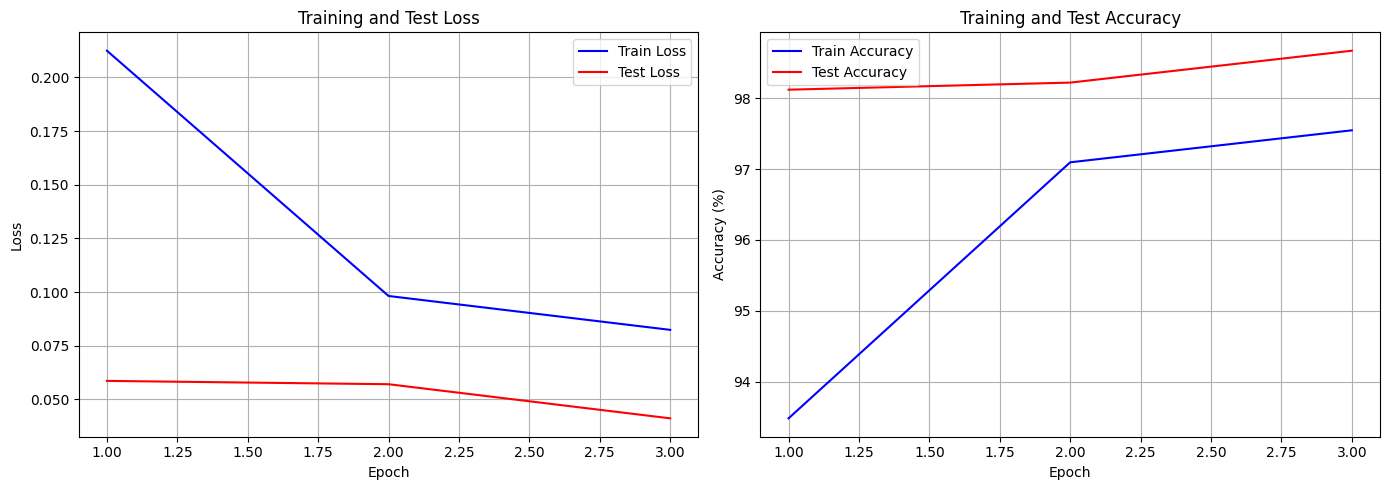

In [19]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(range(1, num_epochs+1), train_losses, 'b-', label='Train Loss')
ax1.plot(range(1, num_epochs+1), test_losses, 'r-', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(range(1, num_epochs+1), train_accs, 'b-', label='Train Accuracy')
ax2.plot(range(1, num_epochs+1), test_accs, 'r-', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 10. Test Predictions

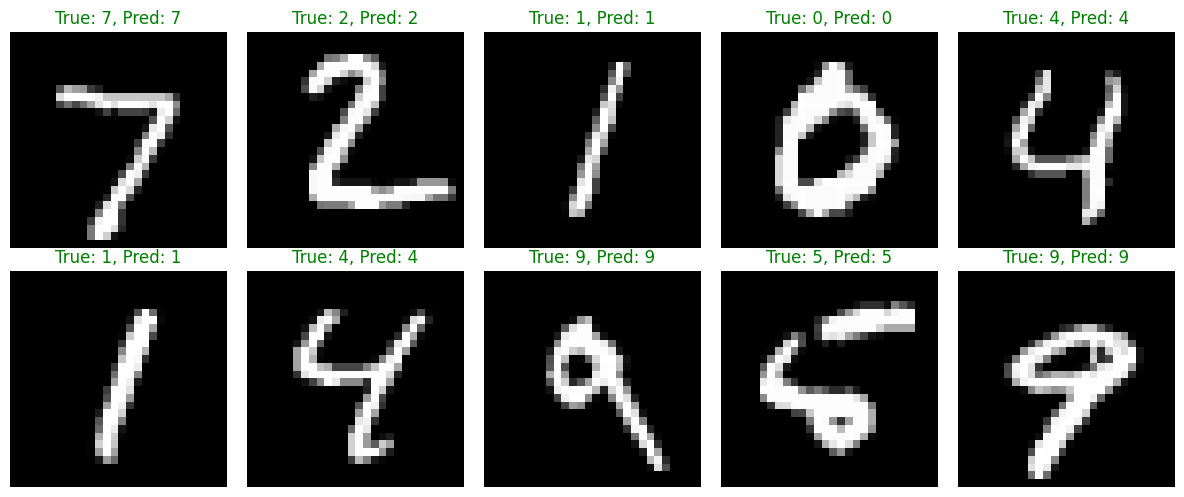

In [11]:
# Get some test samples and make predictions
model.eval()
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
    example_data = example_data.to(device)
    output = model(example_data)
    predictions = torch.argmax(output, dim=1).cpu().numpy()

# Visualize predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(example_data[i][0].cpu(), cmap='gray')
    true_label = example_targets[i].item()
    pred_label = predictions[i]
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {pred_label}', color=color)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

1. **CNN Architecture**: Built a simple CNN with 2 Conv2D layers and Batch Normalization
2. **Layer Components**:
   - Conv2D layers for feature extraction
   - BatchNorm2D for normalizing activations
   - MaxPool2D for downsampling
   - Fully connected layers for classification
3. **Forward Pass**: Demonstrated how data flows through the network
4. **Feature Maps**: Visualized intermediate representations learned by conv layers
5. **Training Loop**: Complete training and evaluation pipeline
6. **Results**: Achieved >95% accuracy on MNIST dataset

Key concepts:
- **Conv2D**: Applies 2D convolution to extract spatial features
- **BatchNorm**: Normalizes layer inputs to improve training stability and speed
- **Pooling**: Reduces spatial dimensions while retaining important features
- **Activation Functions**: Introduce non-linearity (ReLU)